In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from qiskit import execute, transpile
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.providers.aer.backends import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize

from neqr import NEQR

In [2]:
image_neqr = NEQR()
shots = 8192
backend = AerSimulator()

In [3]:
astronaut = data.astronaut()

In [4]:
astronaut.shape

(512, 512, 3)

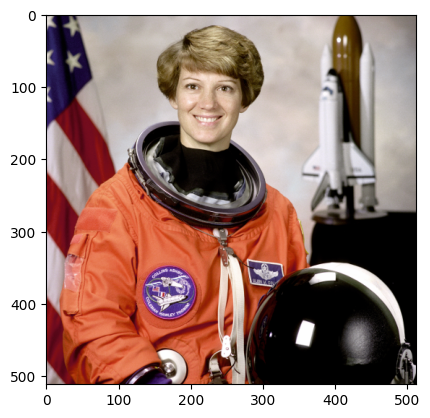

In [5]:
plt.imshow(astronaut)
plt.show()

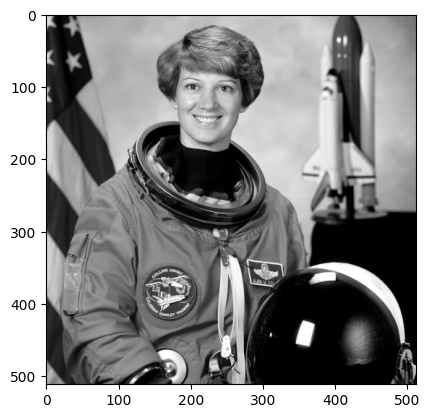

In [6]:
gray_astro = rgb2gray(astronaut)
plt.imshow(gray_astro, cmap="gray")
plt.show()

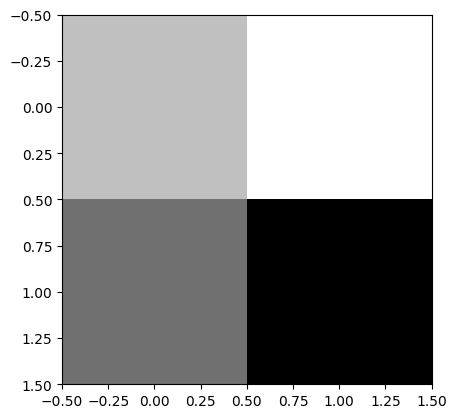

In [7]:
resized_gray_astro = resize(gray_astro, (2,2))
plt.imshow(resized_gray_astro, cmap="gray")

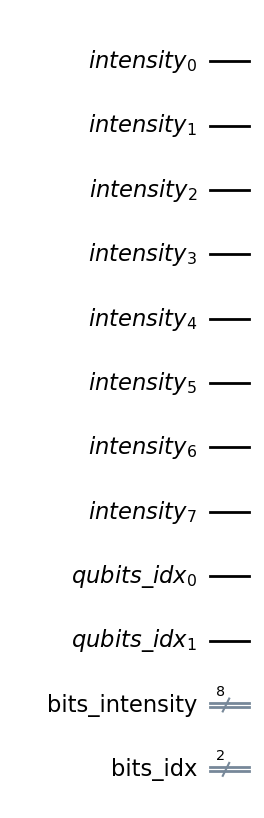

In [8]:
qubits_idx = QuantumRegister(size=2, name="qubits_idx")
intensity = QuantumRegister(size=8, name="intensity")
bits_idx = ClassicalRegister(size=2, name="bits_idx")
bits_intensity = ClassicalRegister(size=8, name="bits_intensity")

qc = QuantumCircuit(intensity, qubits_idx, bits_intensity, bits_idx)
qc.draw(output="mpl")

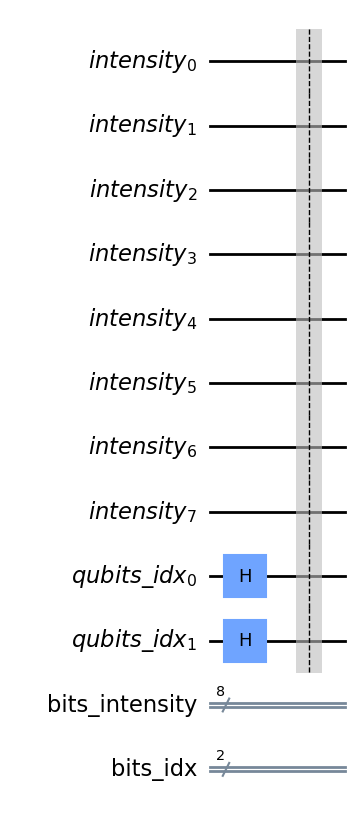

In [9]:
qc.h(qubit=qubits_idx)
qc.barrier()
qc.draw(output="mpl")

In [10]:
pixel_pos_intensity = []

for row in resized_gray_astro:
    for item in row:
        pixel_pos_intensity.append(int(np.round(255*item)))
        
bin_list = [bin(num)[2:] for num in pixel_pos_intensity]

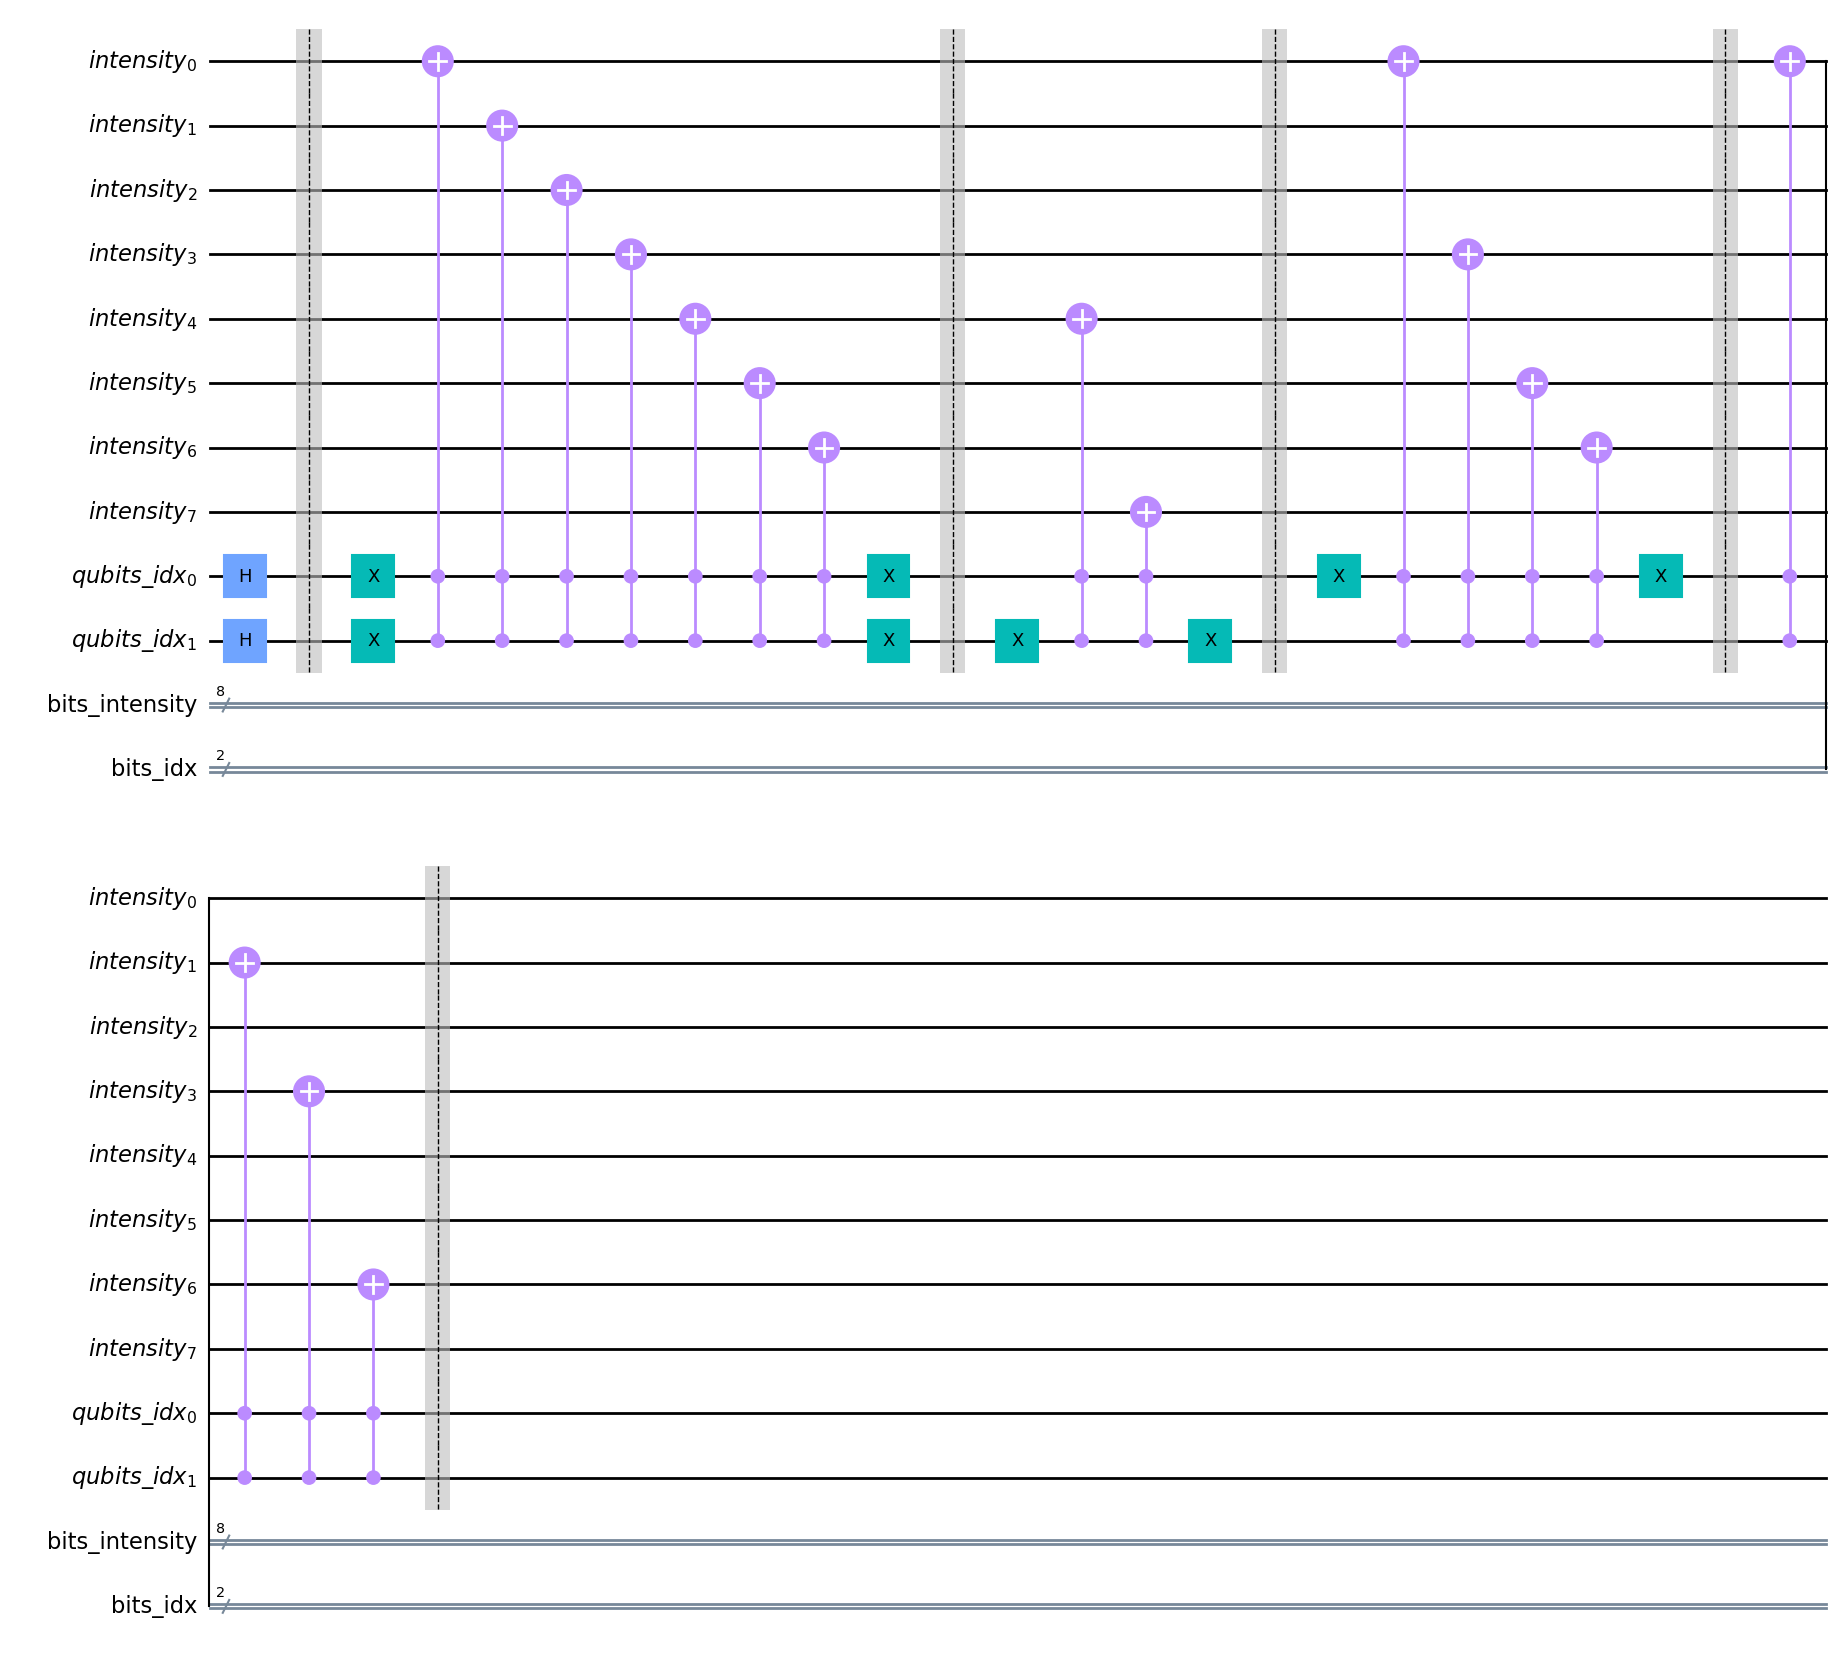

In [11]:
for idx, bnum in enumerate(bin_list):
    
    if idx == 0:
        qc.x(qubit=qubits_idx)
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx)
        qc.barrier()
    elif idx == 1:
        qc.x(qubit=qubits_idx[1])
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx[1])
        qc.barrier()
    elif idx == 2:
        qc.x(qubit=qubits_idx[0])
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.x(qubit=qubits_idx[0])
        qc.barrier()
    else:
        for pos, item in enumerate(bnum[::-1]):
            if item == "1":
                qc.mct(control_qubits=qubits_idx, target_qubit=intensity[pos])
        qc.barrier()
        
qc.draw(output="mpl")

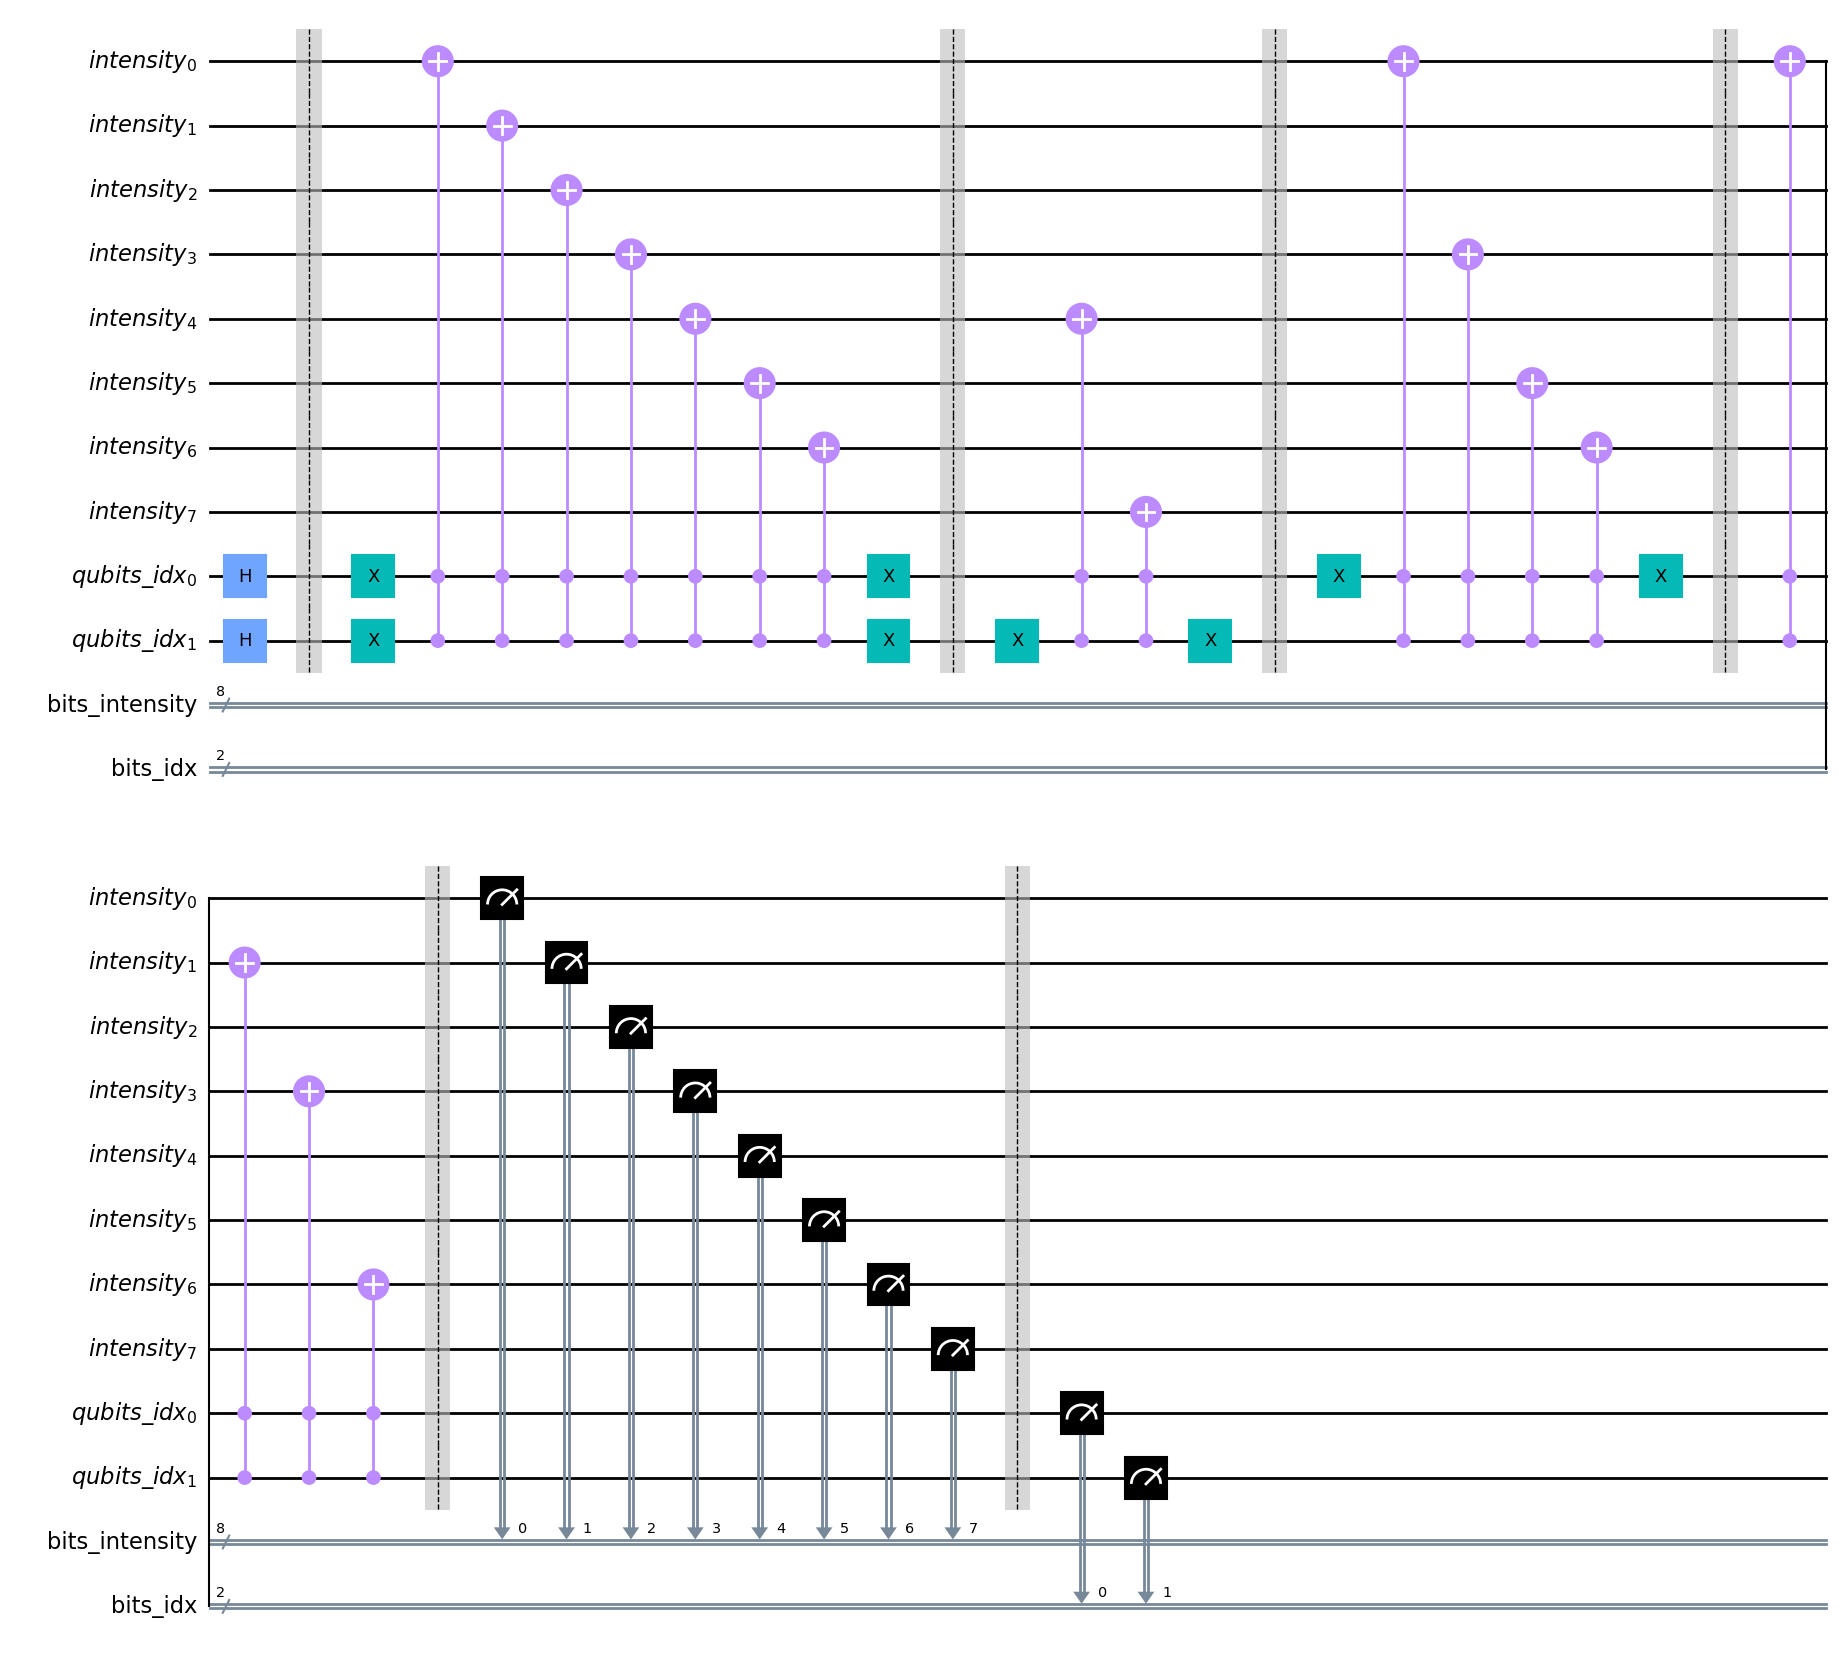

In [12]:
qc.measure(qubit=intensity, cbit=bits_intensity)
qc.barrier()
qc.measure(qubit=qubits_idx, cbit=bits_idx)
qc.draw(output="mpl")

In [13]:
print("Circuit dimensions")
print(f"Circuit depth: {qc.depth()}")
print(f"Circuit size: {qc.size()}")
print(f"Circuit operations: {qc.count_ops()}")

Circuit dimensions
Circuit depth: 26
Circuit size: 37
Circuit operations: OrderedDict([('ccx', 17), ('measure', 10), ('x', 8), ('barrier', 6), ('h', 2)])


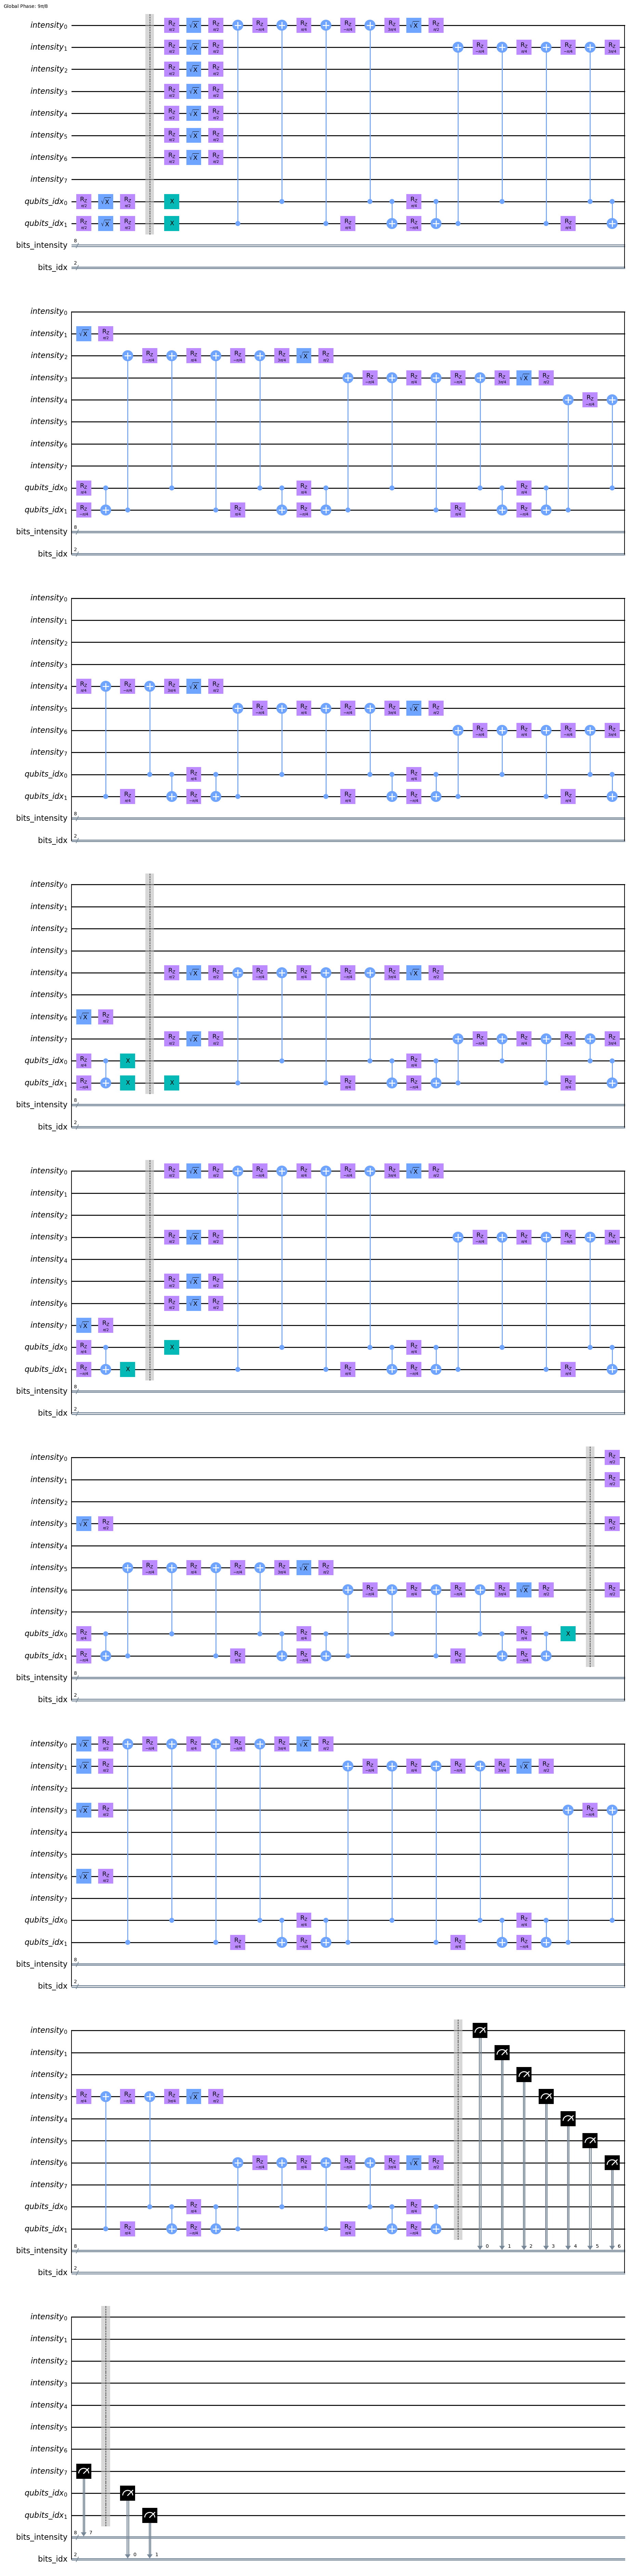

In [14]:
transpiled_qc = transpile(circuits=qc, basis_gates=["id", "x", "sx", "cx", "rz"])
transpiled_qc.draw(output="mpl")

In [15]:
print("Circuit dimensions")
print(f"Circuit depth: {transpiled_qc.depth()}")
print(f"Circuit size: {transpiled_qc.size()}")
print(f"Circuit operations: {transpiled_qc.count_ops()}")

Circuit dimensions
Circuit depth: 190
Circuit size: 330
Circuit operations: OrderedDict([('rz', 174), ('cx', 102), ('sx', 36), ('measure', 10), ('x', 8), ('barrier', 6)])


In [16]:
qcircuit = image_neqr.image_quantum_circuit(image=resized_gray_astro, measurements=True)

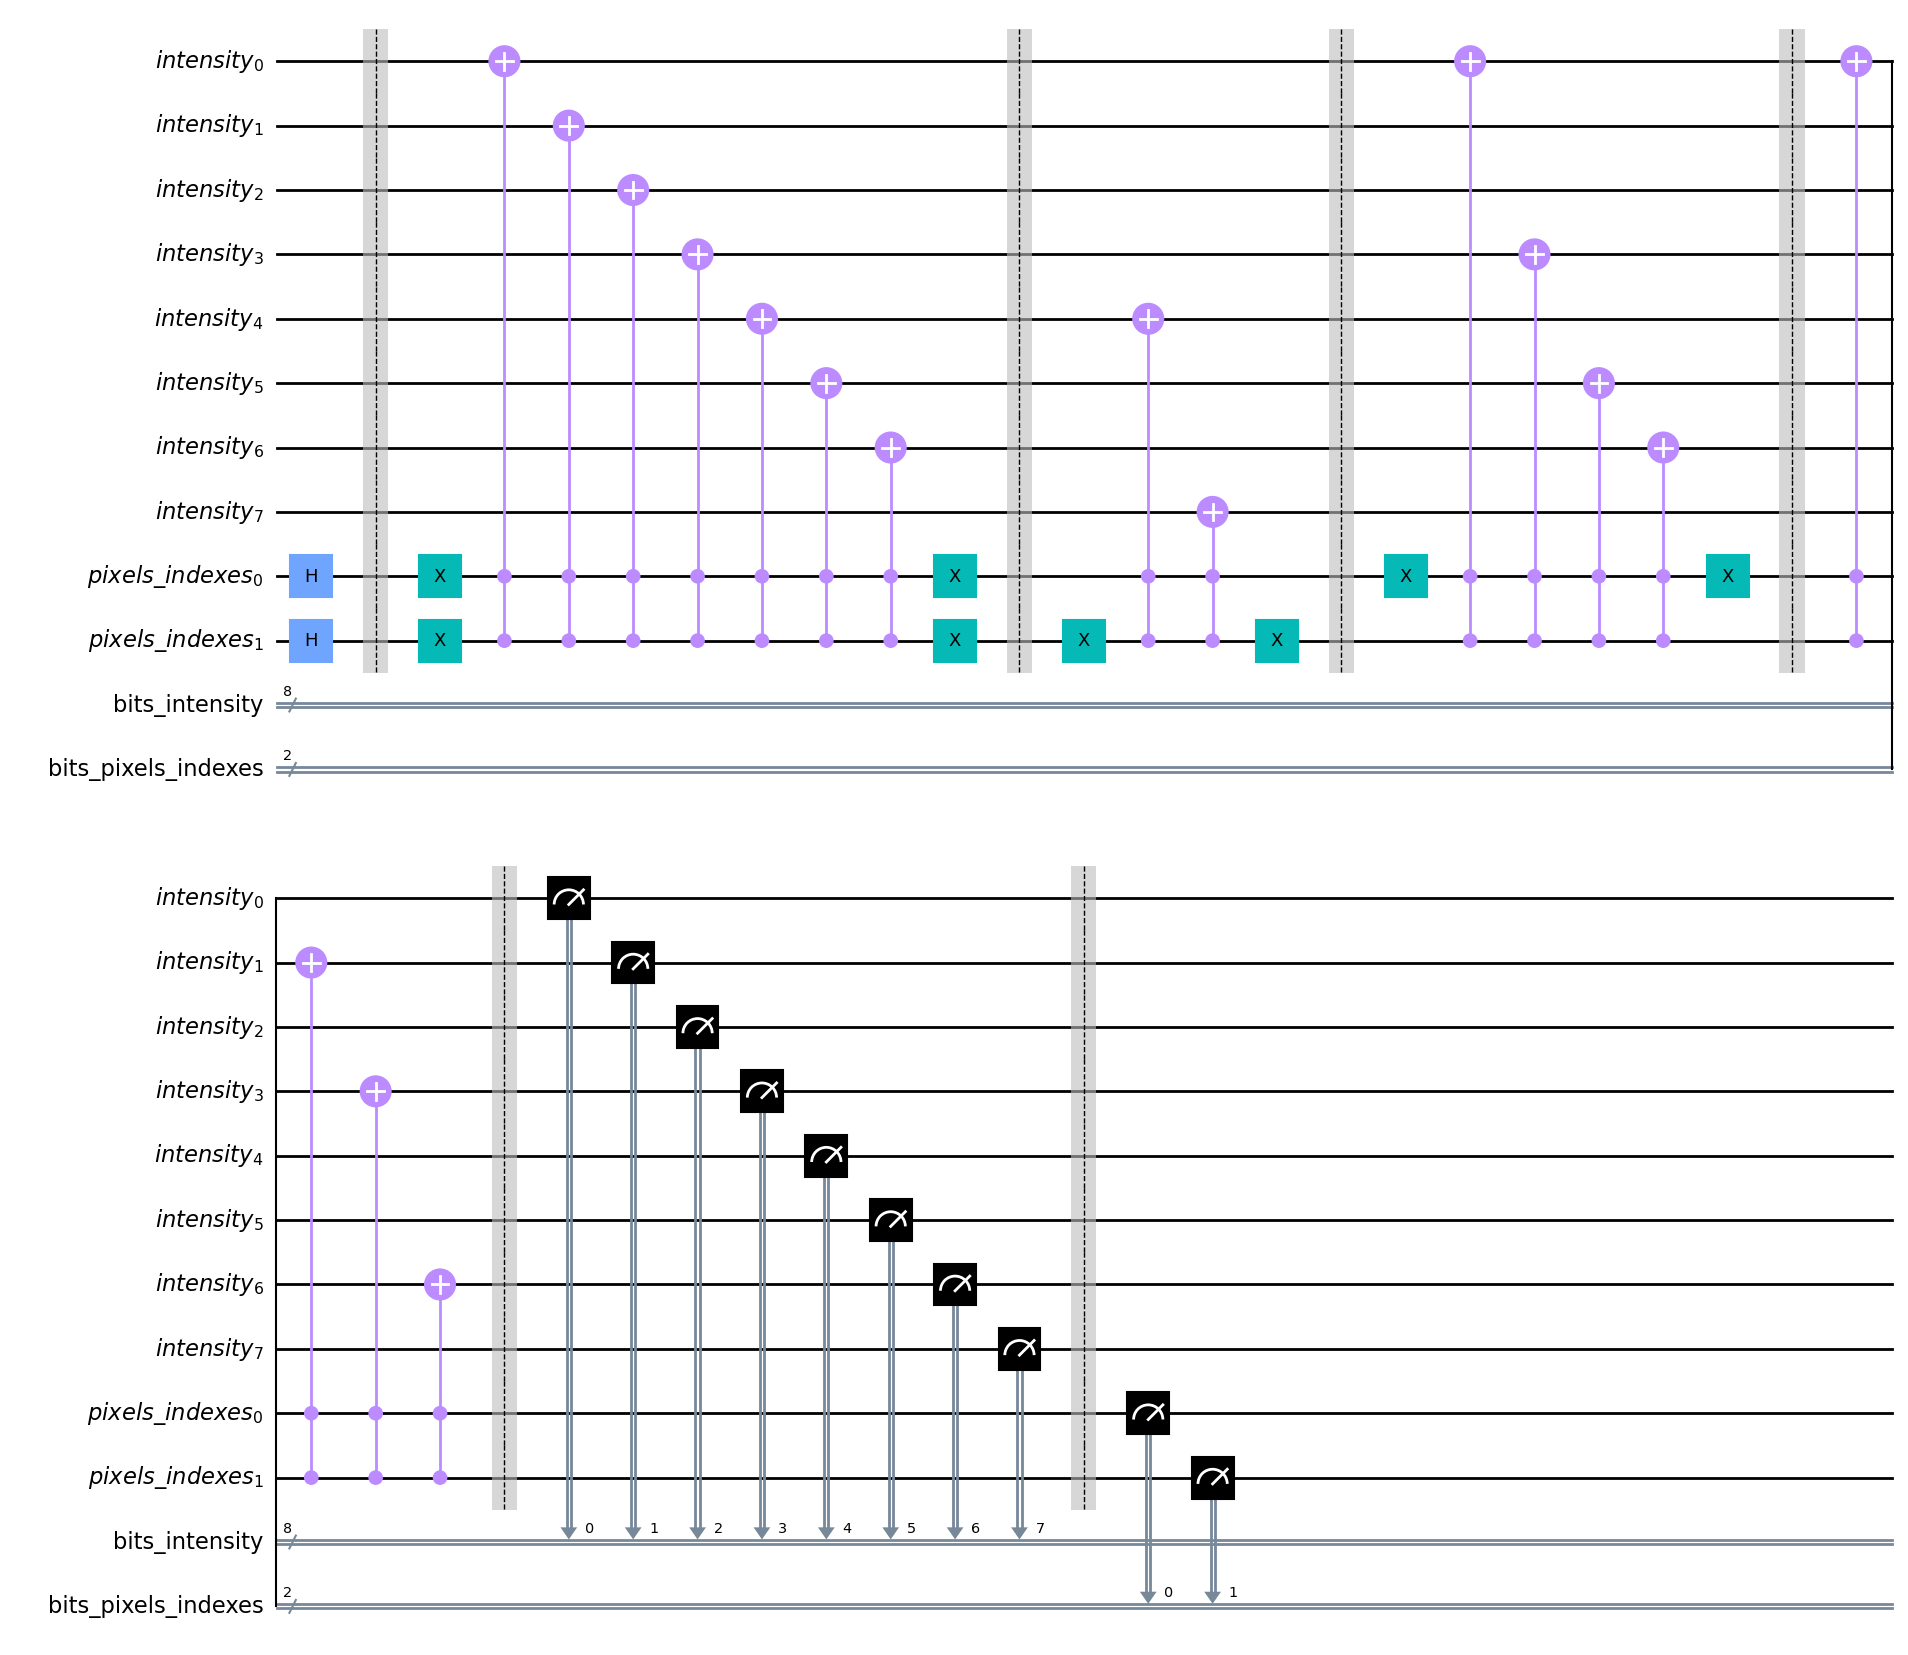

In [17]:
qcircuit.draw(output="mpl")

In [18]:
print("Circuit dimensions")
print(f"Circuit depth: {qcircuit.depth()}")
print(f"Circuit size: {qcircuit.size()}")
print(f"Circuit operations: {qcircuit.count_ops()}")

Circuit dimensions
Circuit depth: 26
Circuit size: 37
Circuit operations: OrderedDict([('ccx', 17), ('measure', 10), ('x', 8), ('barrier', 6), ('h', 2)])


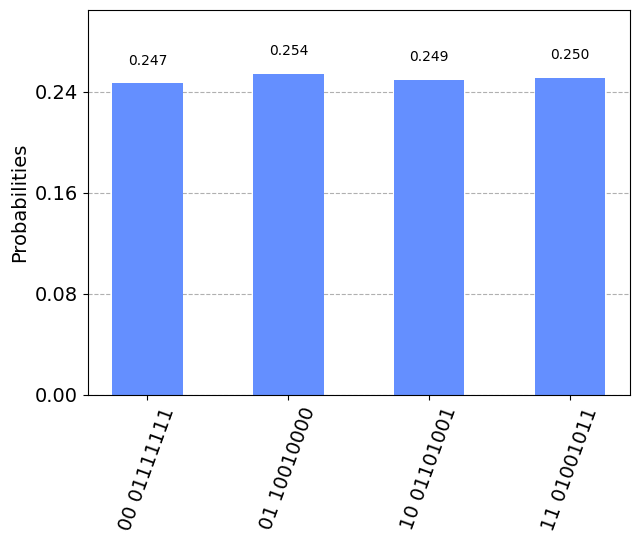

In [19]:
counts = execute(experiments=qcircuit, backend=backend, shots=shots).result().get_counts()
plot_histogram(counts)

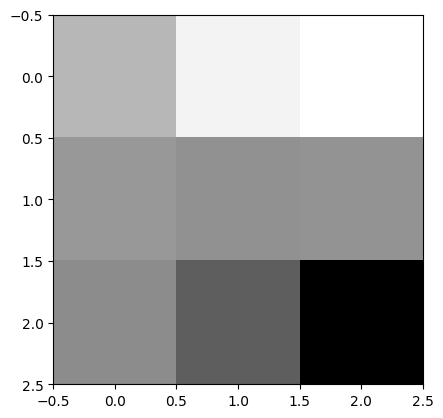

In [20]:
resized_gray_astro_33 = resize(gray_astro, (3,3))
plt.imshow(resized_gray_astro_33, cmap="gray")

In [21]:
qcircuit = image_neqr.image_quantum_circuit(image=resized_gray_astro_33, measurements=True)

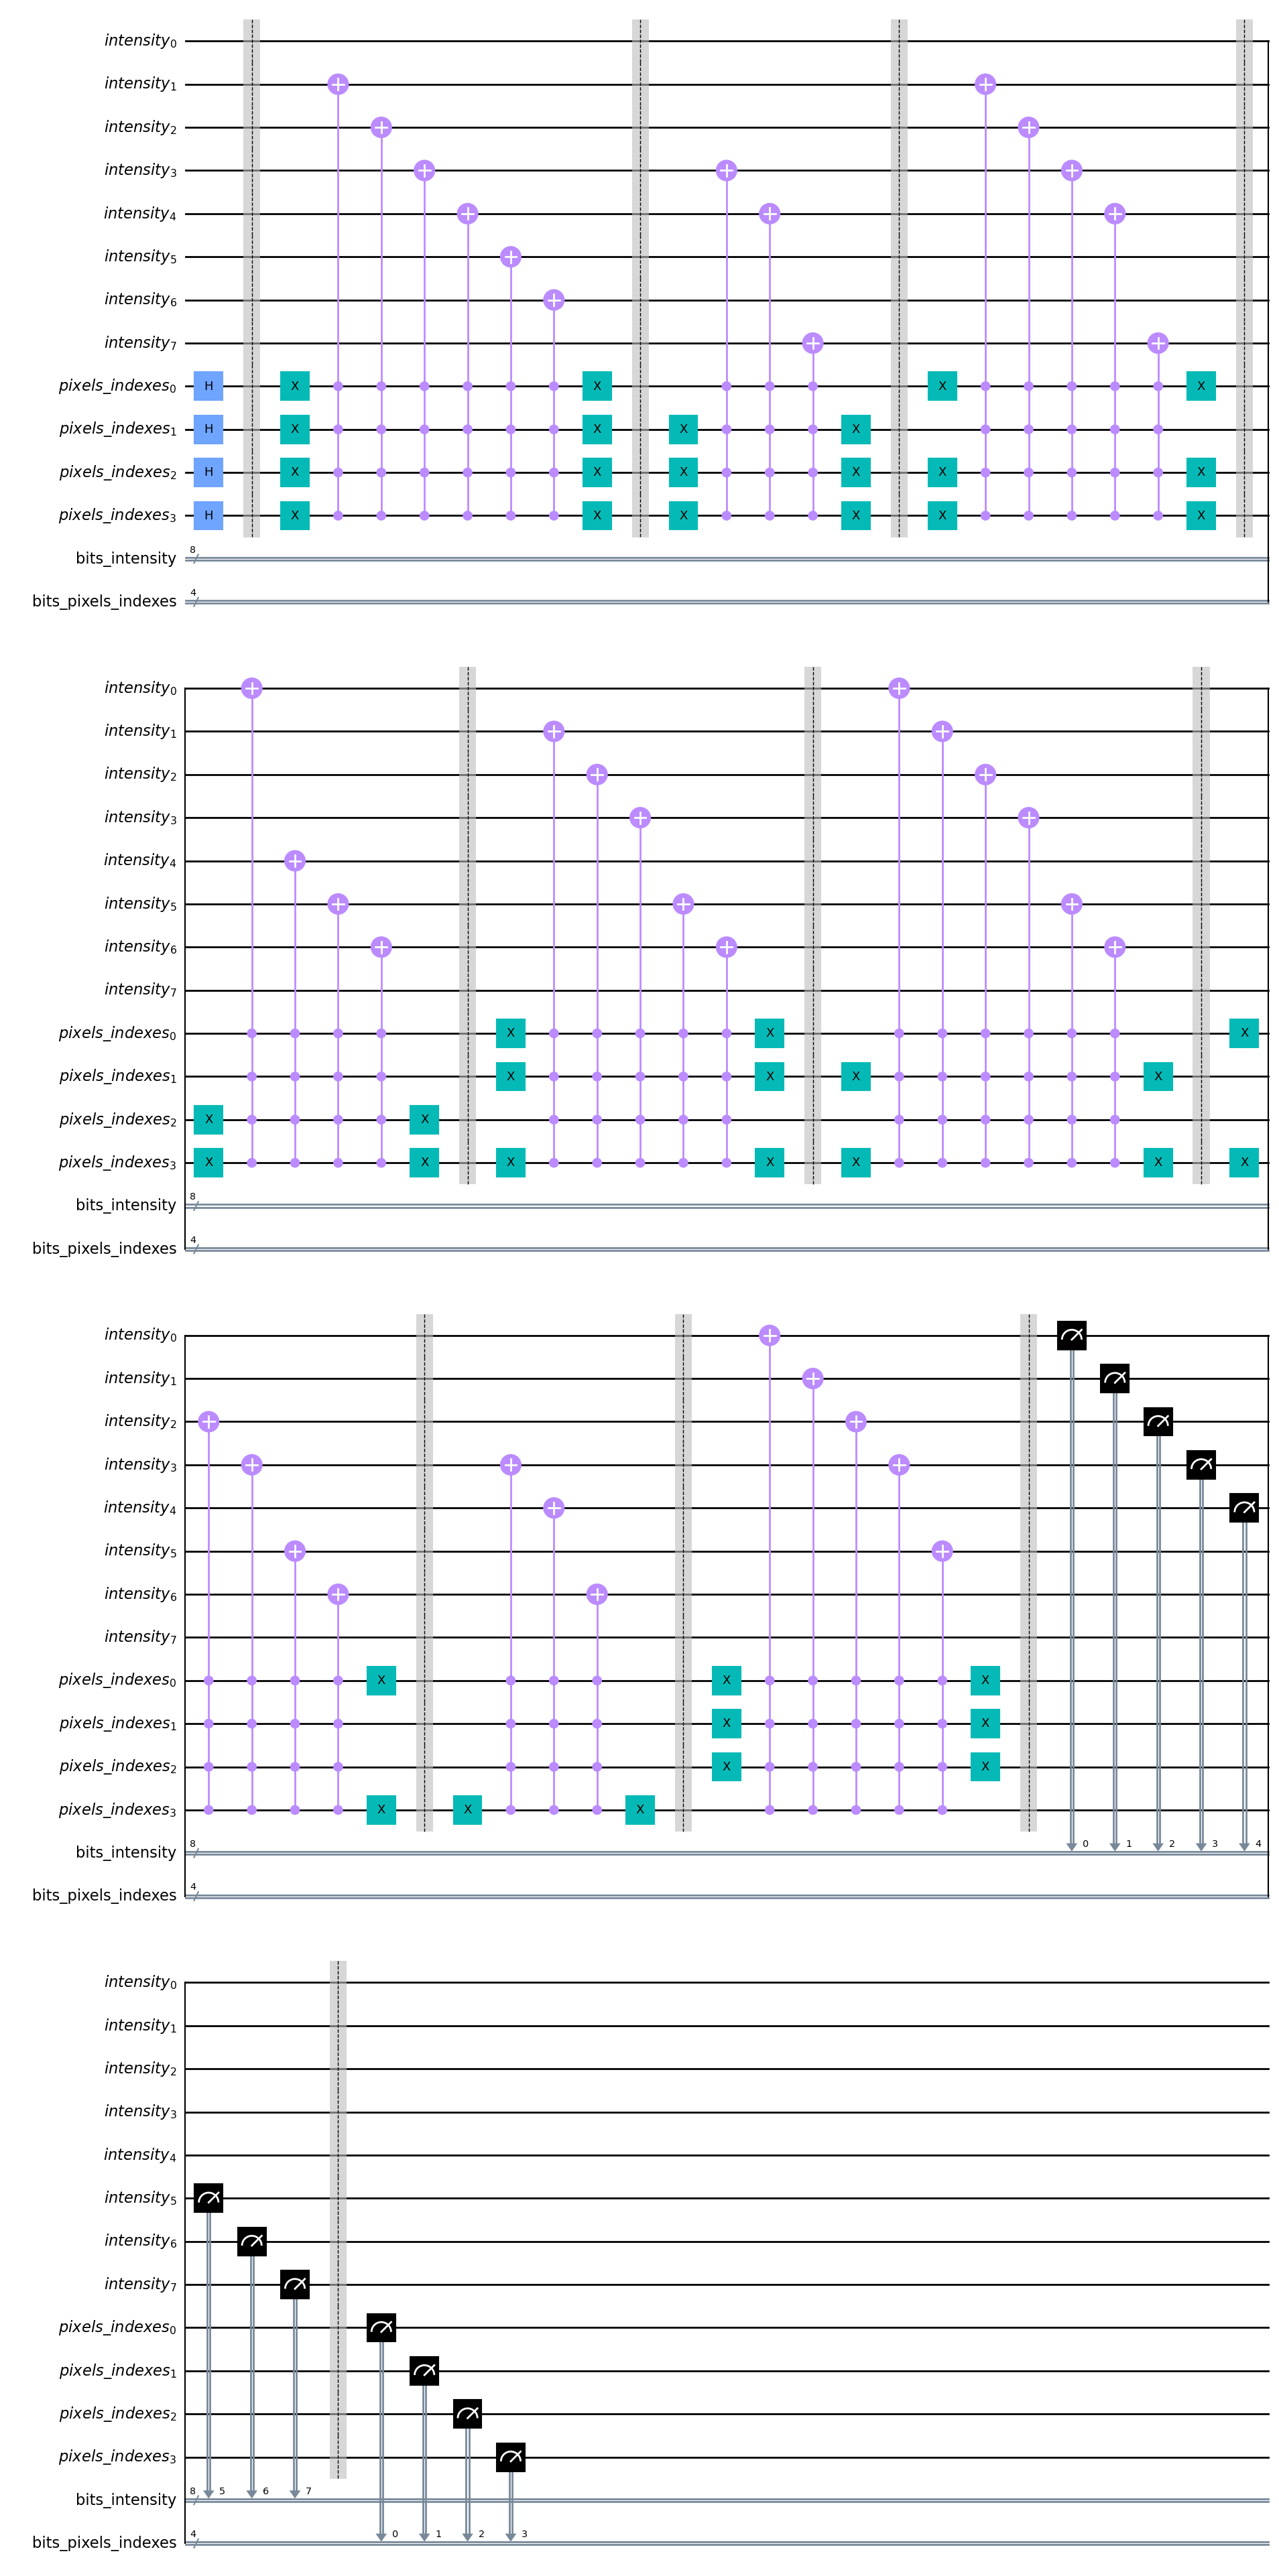

In [22]:
qcircuit.draw(output="mpl")

In [23]:
print("Circuit dimensions")
print(f"Circuit depth: {qcircuit.depth()}")
print(f"Circuit size: {qcircuit.size()}")
print(f"Circuit operations: {qcircuit.count_ops()}")

Circuit dimensions
Circuit depth: 62
Circuit size: 103
Circuit operations: OrderedDict([('x', 46), ('mcx', 41), ('measure', 12), ('barrier', 11), ('h', 4)])


In [24]:
counts = execute(experiments=qcircuit, backend=backend, shots=shots).result().get_counts()

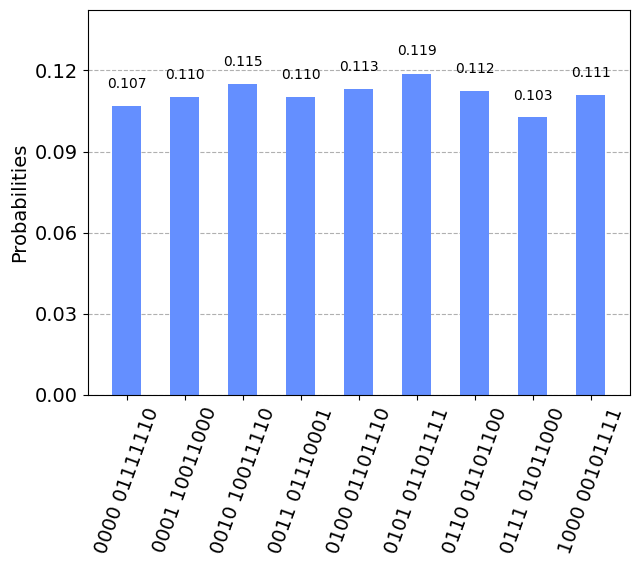

In [25]:
keys_list = [key for key, _ in sorted(counts.items())][:9]
processed_counts = {key: counts[key] for key in keys_list}
plot_histogram(processed_counts)

In [26]:
test_matrix = np.array([[0,0,0],[0,1,0],[0,1,0],[0,0,0]])

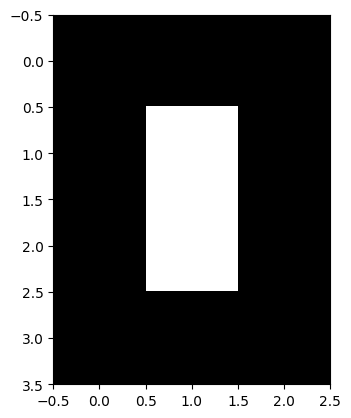

In [27]:
plt.imshow(test_matrix, cmap="gray")

In [28]:
qcircuit = image_neqr.image_quantum_circuit(image=test_matrix, measurements=True)

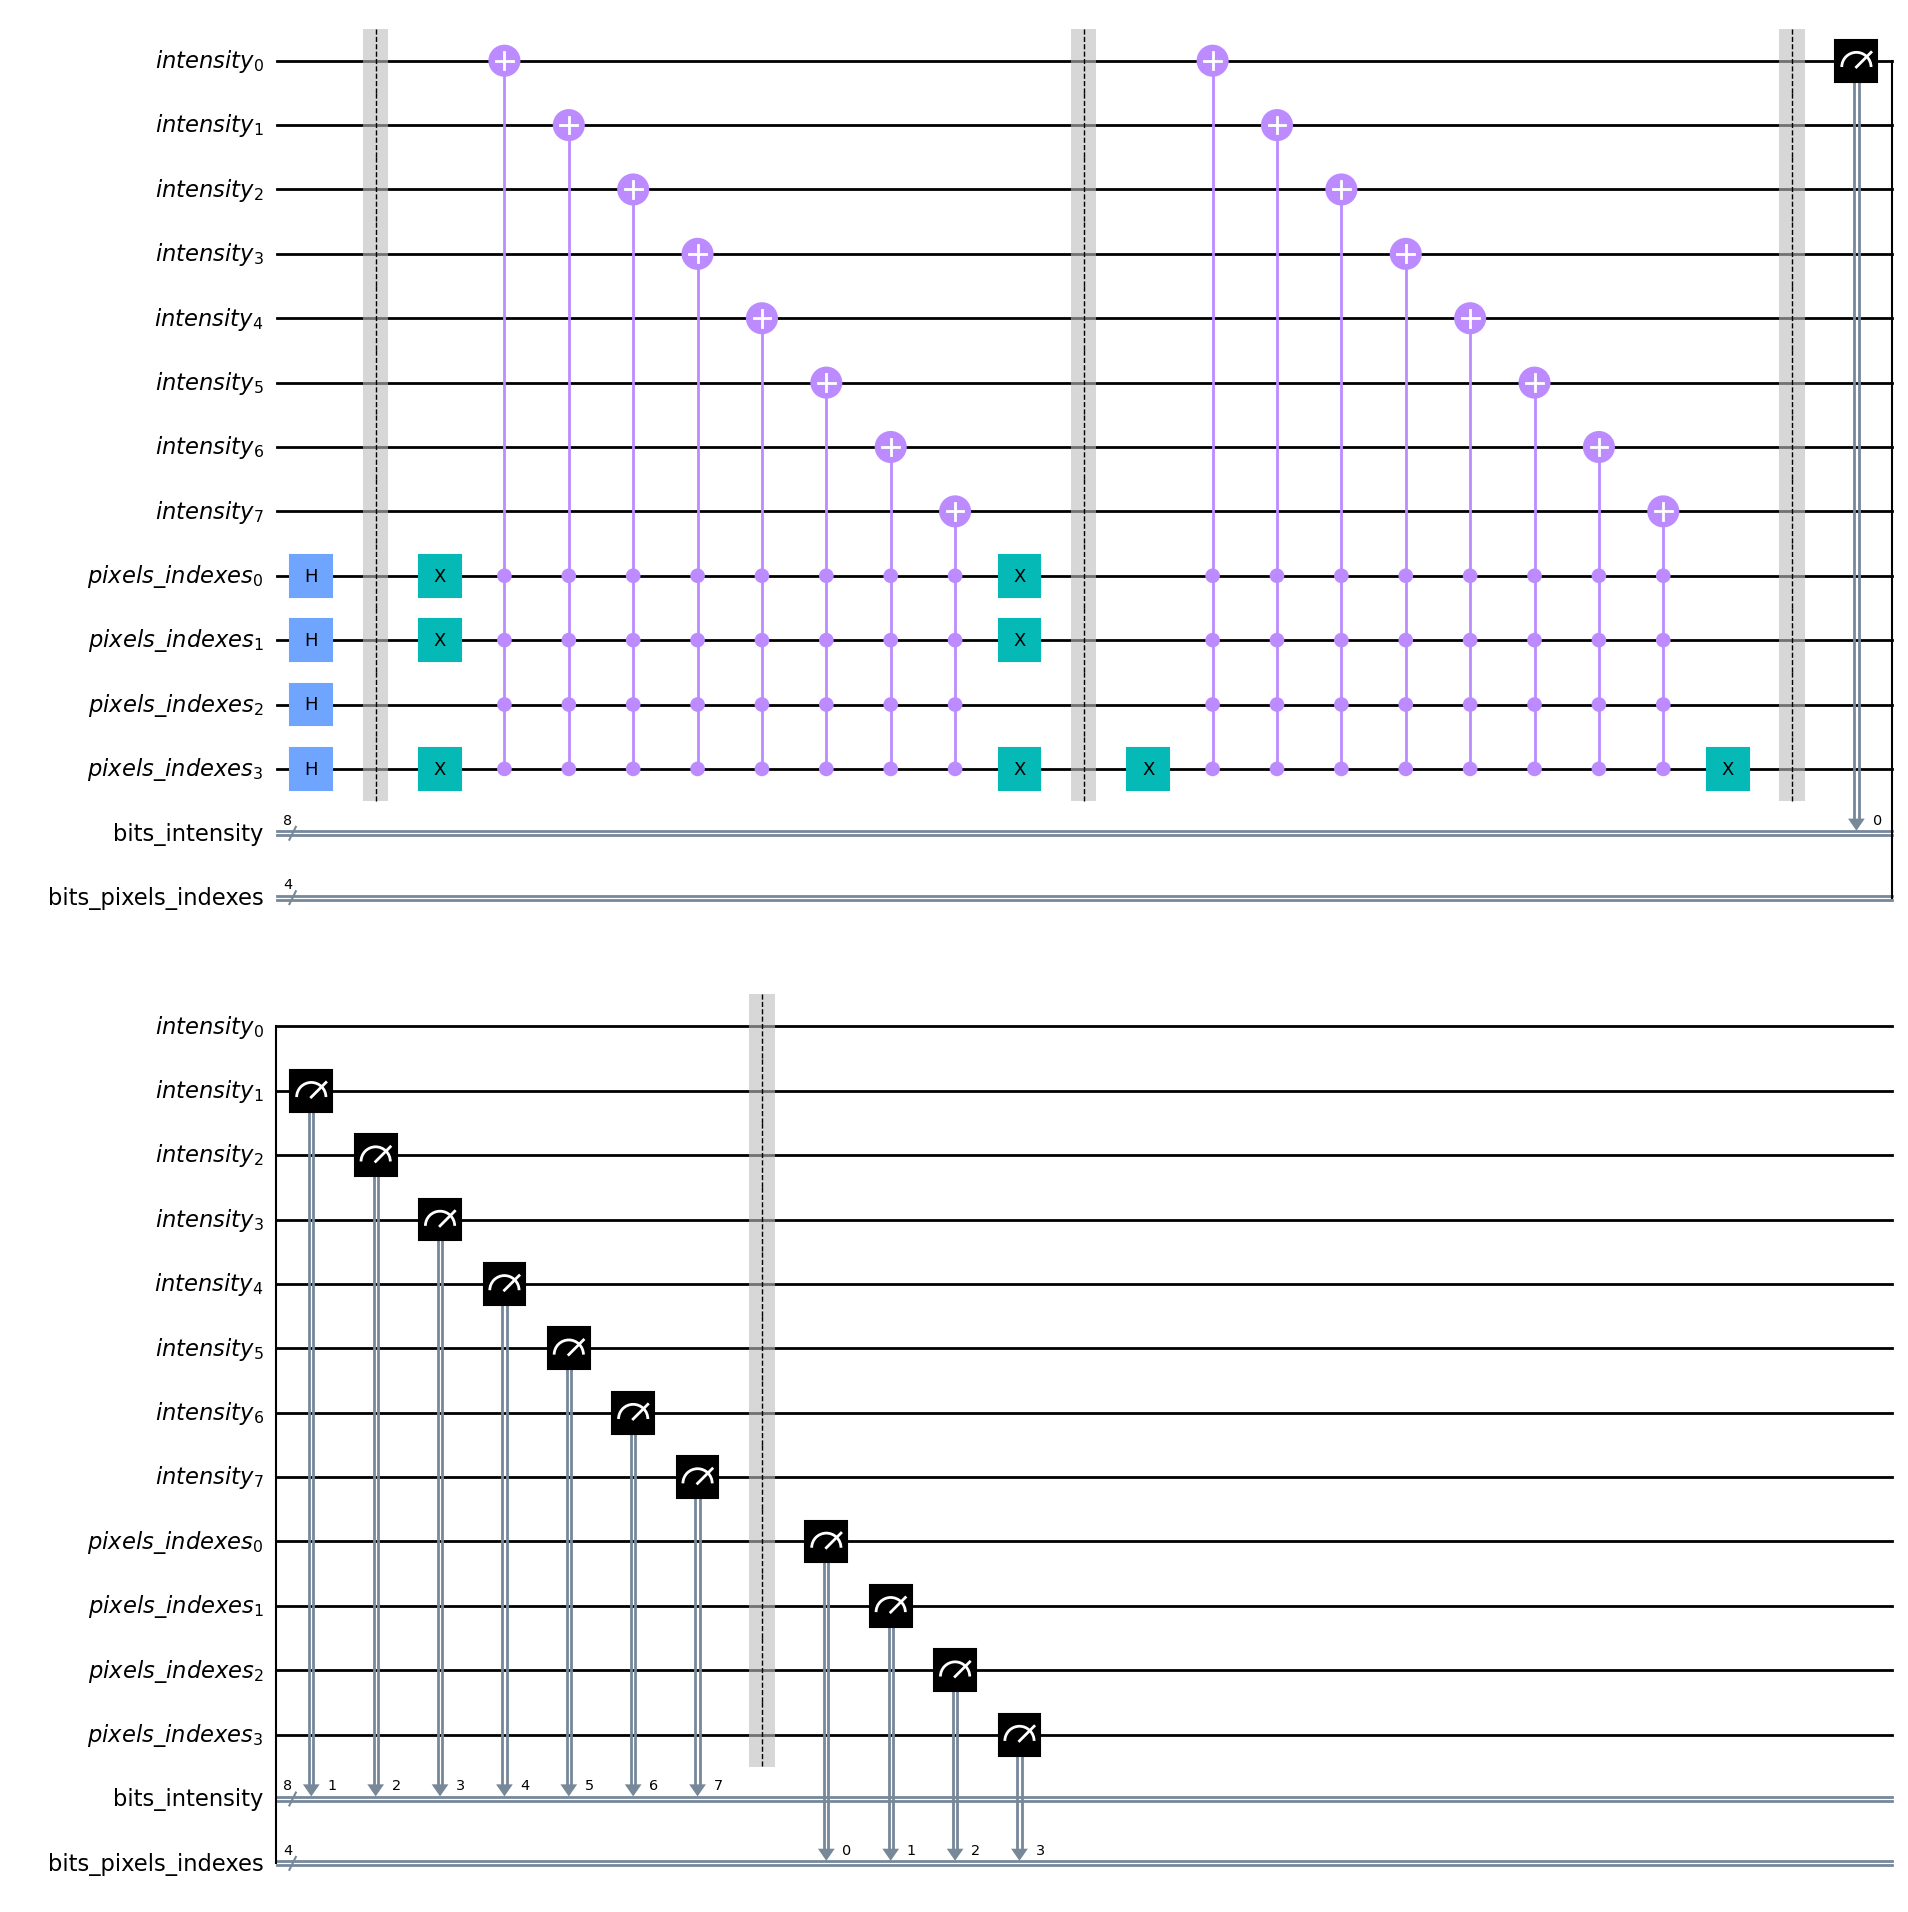

In [29]:
qcircuit.draw(output="mpl")

In [30]:
print("Circuit dimensions")
print(f"Circuit depth: {qcircuit.depth()}")
print(f"Circuit size: {qcircuit.size()}")
print(f"Circuit operations: {qcircuit.count_ops()}")

Circuit dimensions
Circuit depth: 23
Circuit size: 40
Circuit operations: OrderedDict([('mcx', 16), ('measure', 12), ('x', 8), ('h', 4), ('barrier', 4)])


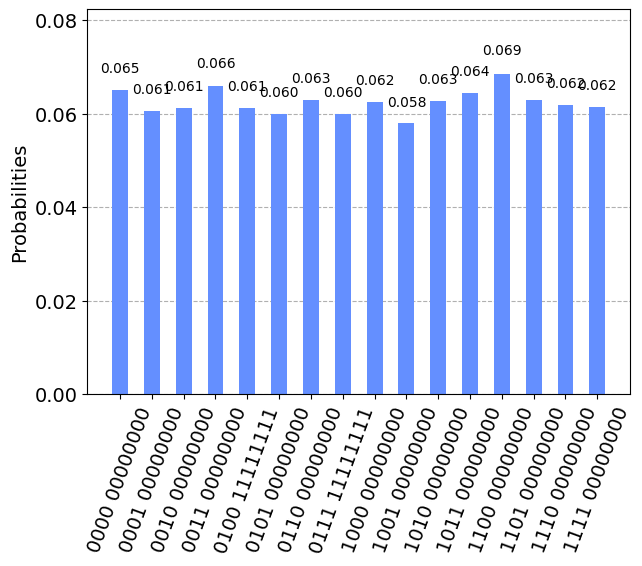

In [31]:
counts = execute(experiments=qcircuit, backend=backend, shots=shots).result().get_counts()
plot_histogram(counts)

In [32]:
test_matrix = np.array([[0,1,0]])

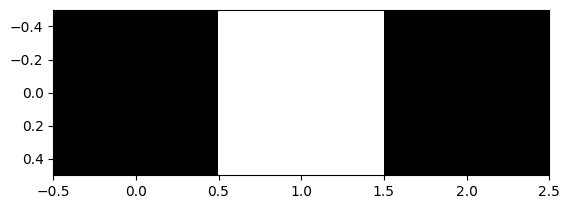

In [33]:
plt.imshow(test_matrix, cmap="gray")

In [34]:
qcircuit = image_neqr.image_quantum_circuit(image=test_matrix, measurements=True)

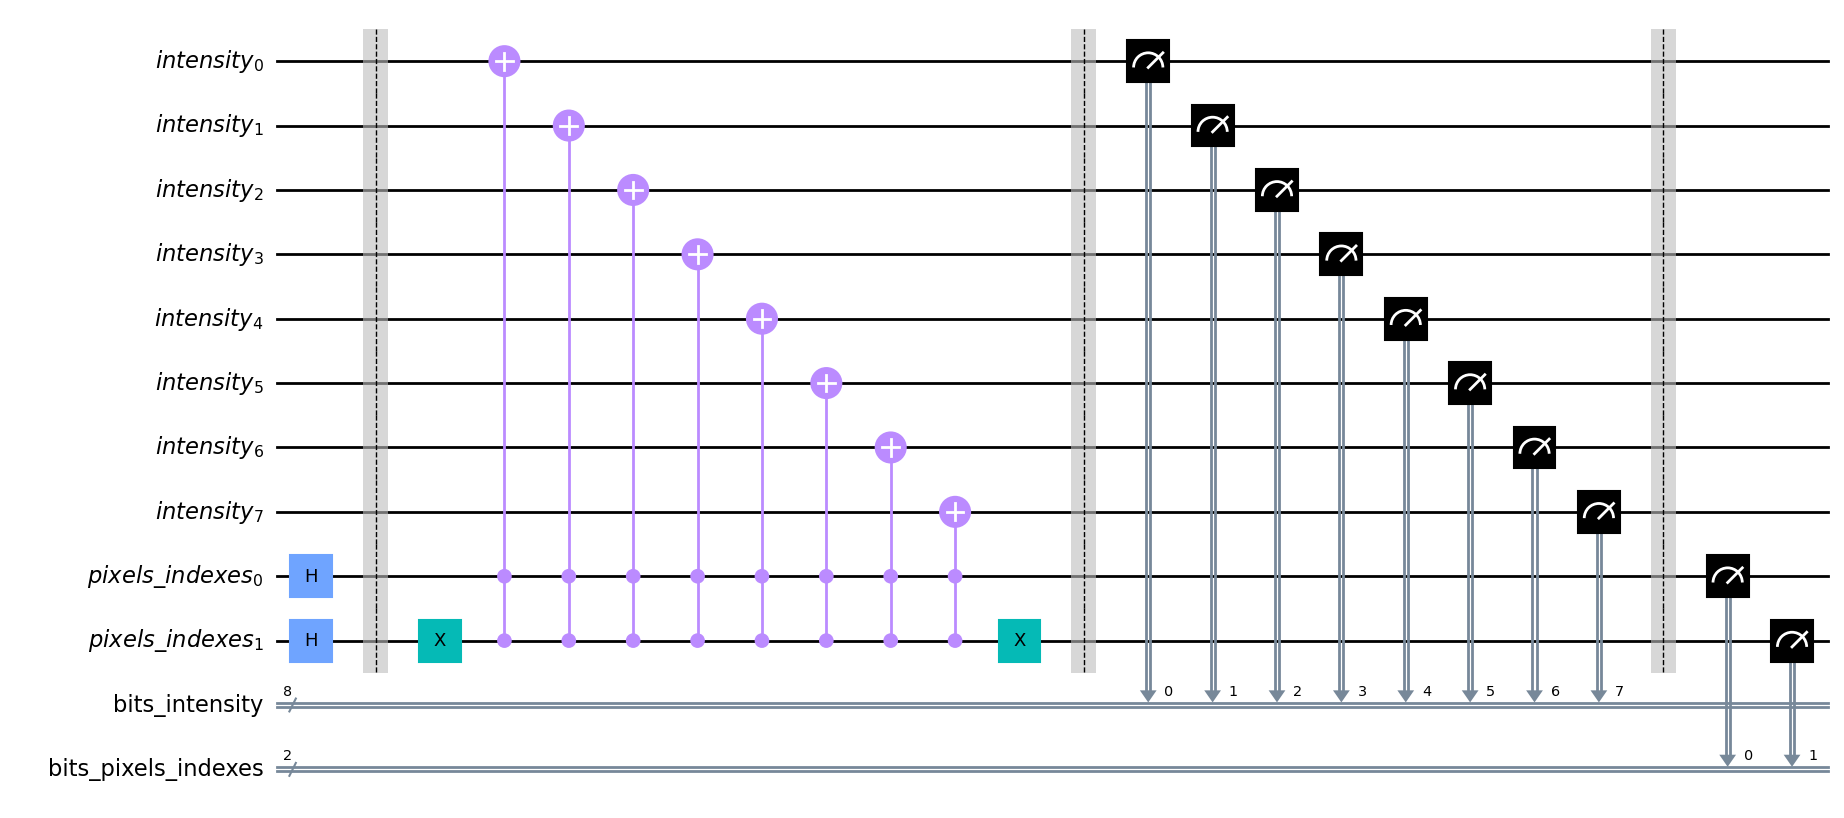

In [35]:
qcircuit.draw(output="mpl")

In [36]:
print("Circuit dimensions")
print(f"Circuit depth: {qcircuit.depth()}")
print(f"Circuit size: {qcircuit.size()}")
print(f"Circuit operations: {qcircuit.count_ops()}")

Circuit dimensions
Circuit depth: 13
Circuit size: 22
Circuit operations: OrderedDict([('measure', 10), ('ccx', 8), ('barrier', 3), ('h', 2), ('x', 2)])


In [37]:
counts = execute(experiments=qcircuit, backend=backend, shots=shots).result().get_counts()

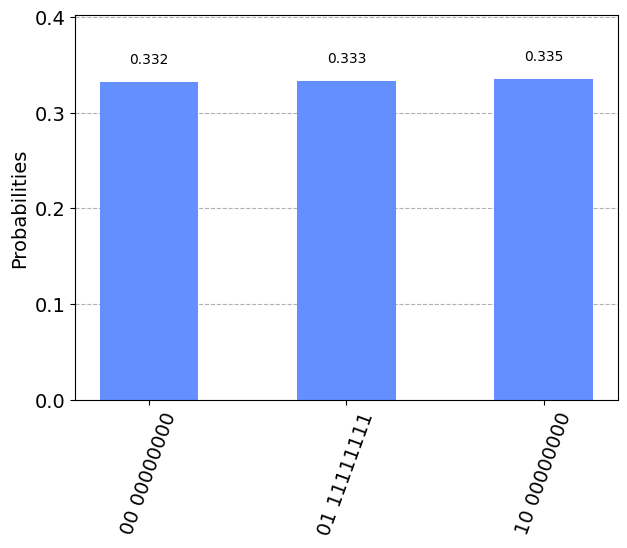

In [38]:
keys_list = [key for key, _ in sorted(counts.items())][:3]
processed_counts = {key: counts[key] for key in keys_list}
plot_histogram(processed_counts)

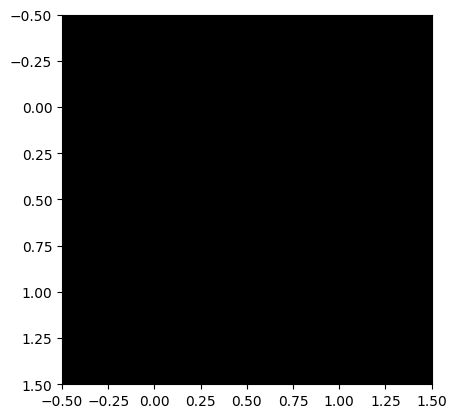

In [39]:
test_image = np.array([[0,0],[0,0]])
plt.imshow(test_image, cmap="gray")

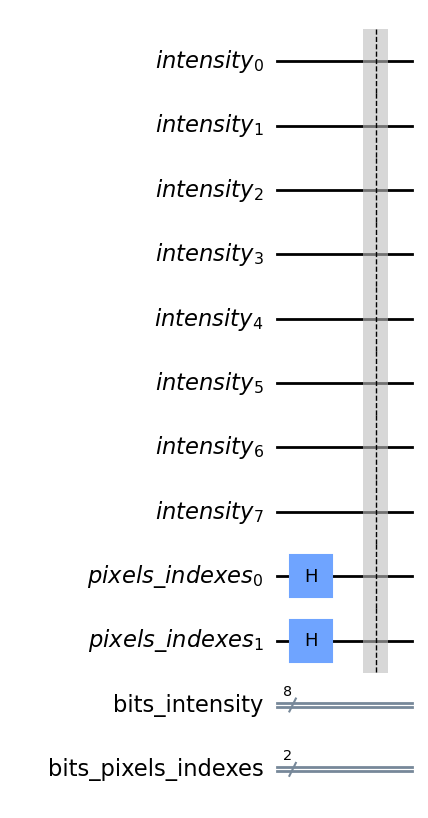

In [40]:
qc = image_neqr.image_quantum_circuit(image=test_image)
qc.draw(output="mpl")

In [41]:
dm = DensityMatrix(data=qc)

In [42]:
dm

DensityMatrix([[0.25+0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               ...,
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j]],
              dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [43]:
dm_reduced = partial_trace(state=dm, qargs=[8,9])

In [44]:
dm_reduced

DensityMatrix([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               ...,
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2, 2, 2, 2, 2, 2, 2))


In [45]:
state_fidelity(dm_reduced, dm_reduced)

1.000000000000048

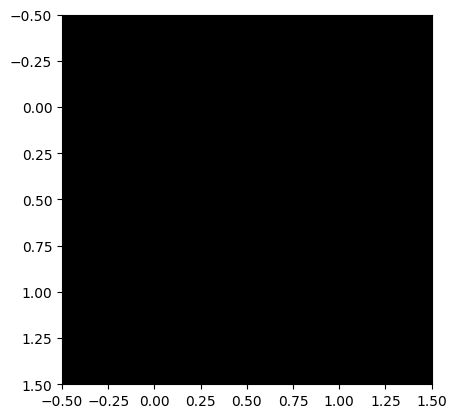

In [46]:
test_image2 = np.array([[1,1],[1,1]])
plt.imshow(test_image2, cmap="gray")

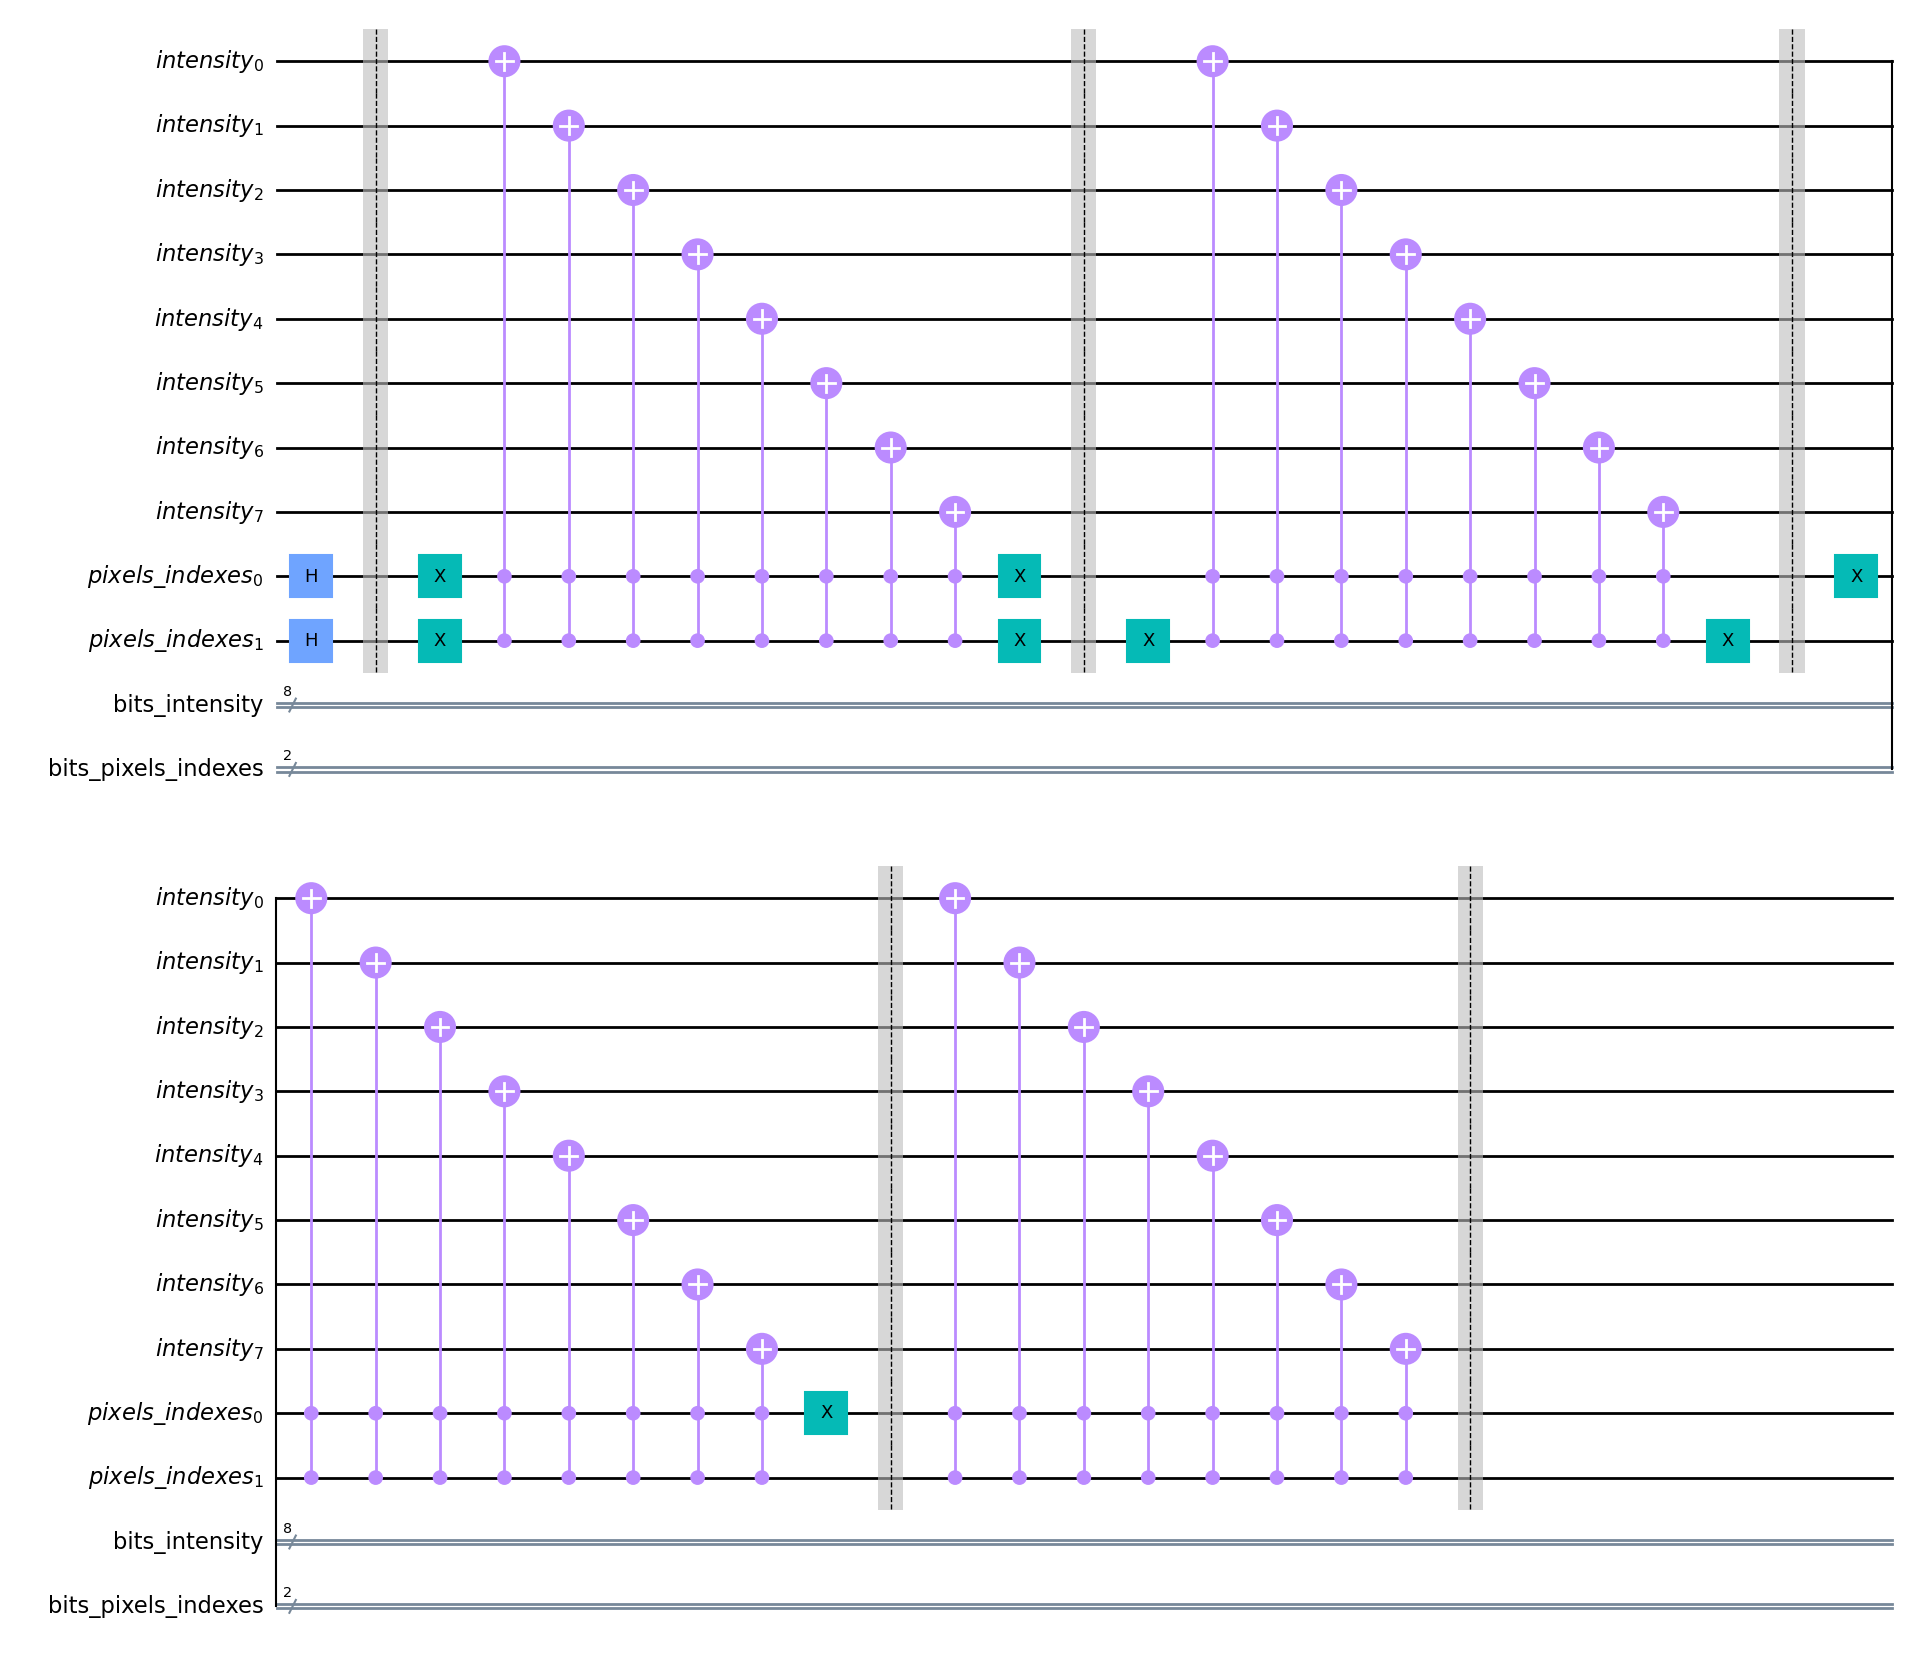

In [47]:
qc2 = image_neqr.image_quantum_circuit(image=test_image2)
qc2.draw(output="mpl")

In [48]:
dm2 = DensityMatrix(data=qc2)

In [49]:
dm2

DensityMatrix([[0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               ...,
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j,
                0.25+0.j]],
              dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [50]:
dm_reduced2 = partial_trace(state=dm2, qargs=[8,9])

In [51]:
dm_reduced2

DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               ...,
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]],
              dims=(2, 2, 2, 2, 2, 2, 2, 2))


In [52]:
state_fidelity(dm_reduced, dm_reduced2)

3.99681303647845e-16

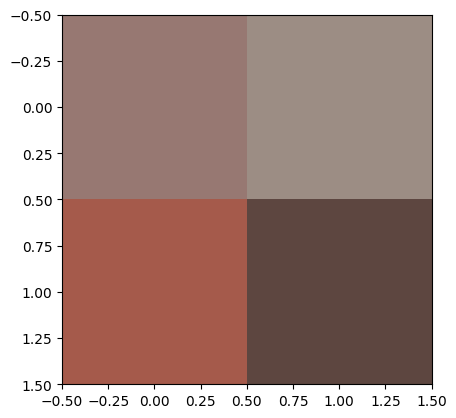

In [53]:
resized_rgb_astro = resize(astronaut, (2,2))
plt.imshow(resized_rgb_astro)

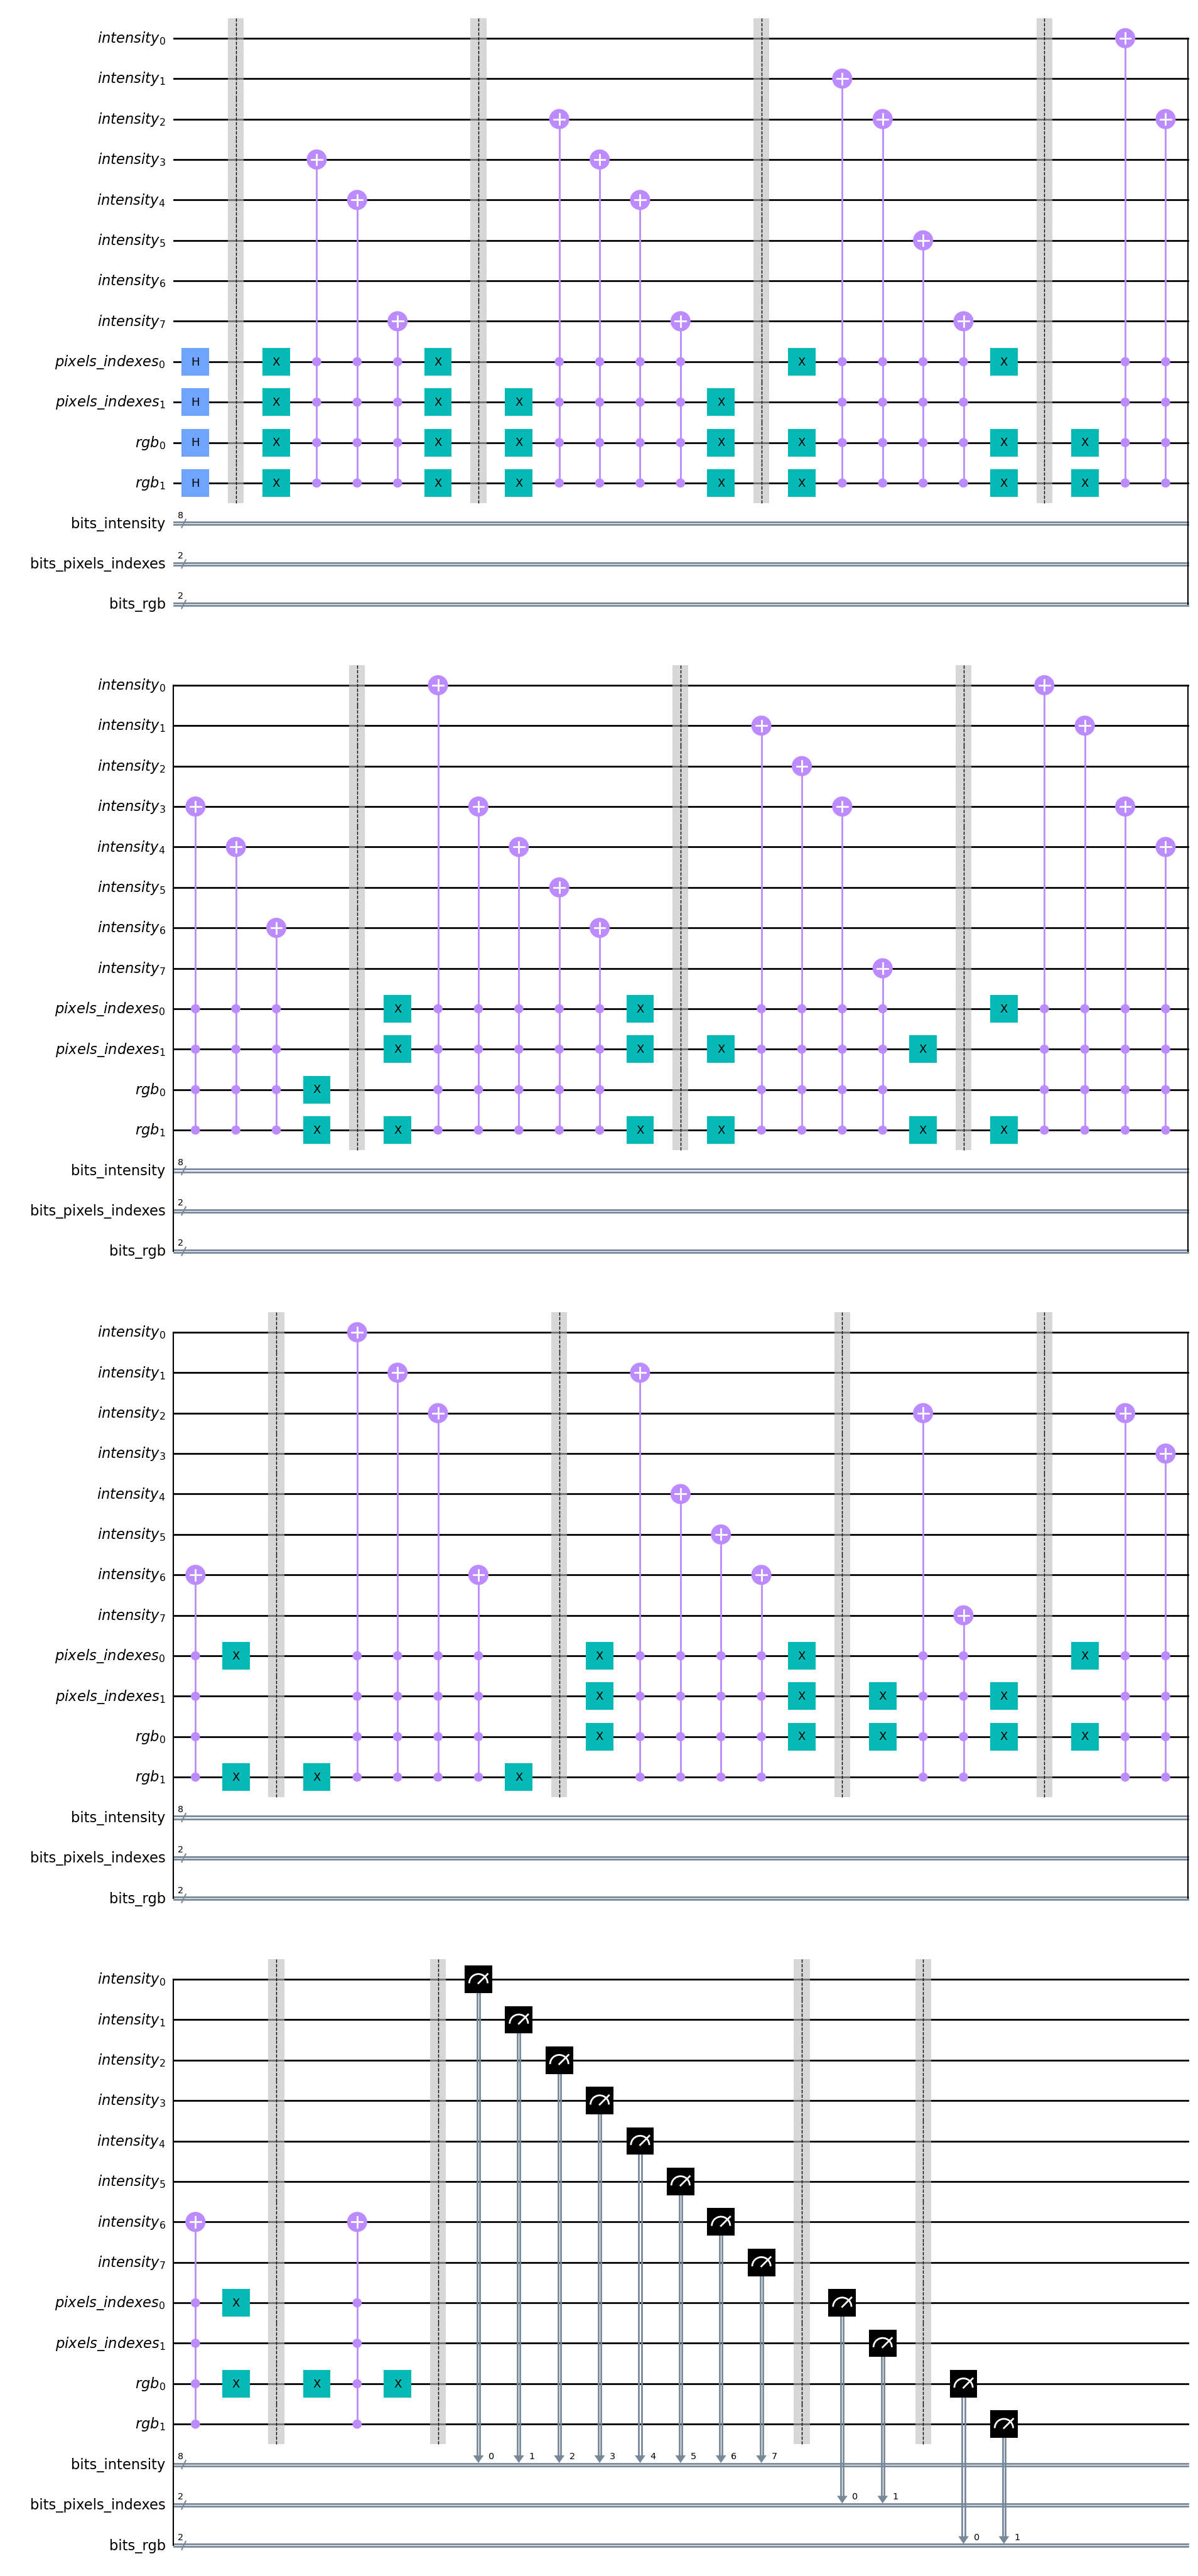

In [54]:
qc = image_neqr.image_quantum_circuit(image=resized_rgb_astro, measurements=True)
qc.draw(output="mpl")

In [55]:
print("Circuit dimensions")
print(f"Circuit depth: {qc.depth()}")
print(f"Circuit size: {qc.size()}")
print(f"Circuit operations: {qc.count_ops()}")

Circuit dimensions
Circuit depth: 72
Circuit size: 116
Circuit operations: OrderedDict([('x', 56), ('mcx', 44), ('barrier', 15), ('measure', 12), ('h', 4)])


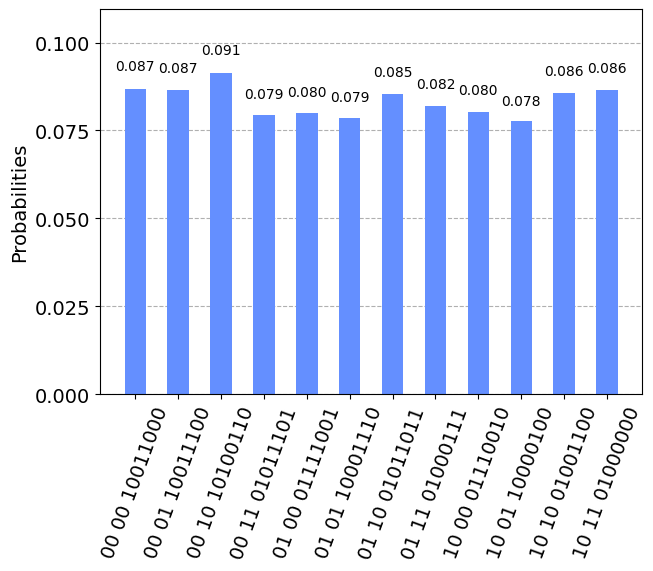

In [56]:
counts = execute(experiments=qc, backend=backend, shots=shots).result().get_counts()
keys_list = [key for key, _ in sorted(counts.items())][:12]
processed_counts = {key: counts[key] for key in keys_list}
plot_histogram(processed_counts)